# Video Transcription 

Une démo sur l'utilisation de plusieurs API de Google pour la génération automatique d'un transcript timé d'une vidéo.
 Le résultat est visible ici : https://storage.googleapis.com/jr-non-uniform/Conseil%20municipal%20du%20mardi%207%20novembre%202023.html 


Cette démo utilise trois API : 
### 1) Google Cloud Storage 
https://cloud.google.com/storage/docs/introduction 
### 2) Cloud Video Intelligence 
https://cloud.google.com/video-intelligence/docs/features 
### 3) Vertex AI PALM 
Gen Ai - modèle Bison002 - https://cloud.google.com/vertex-ai/docs/generative-ai/learn/models 

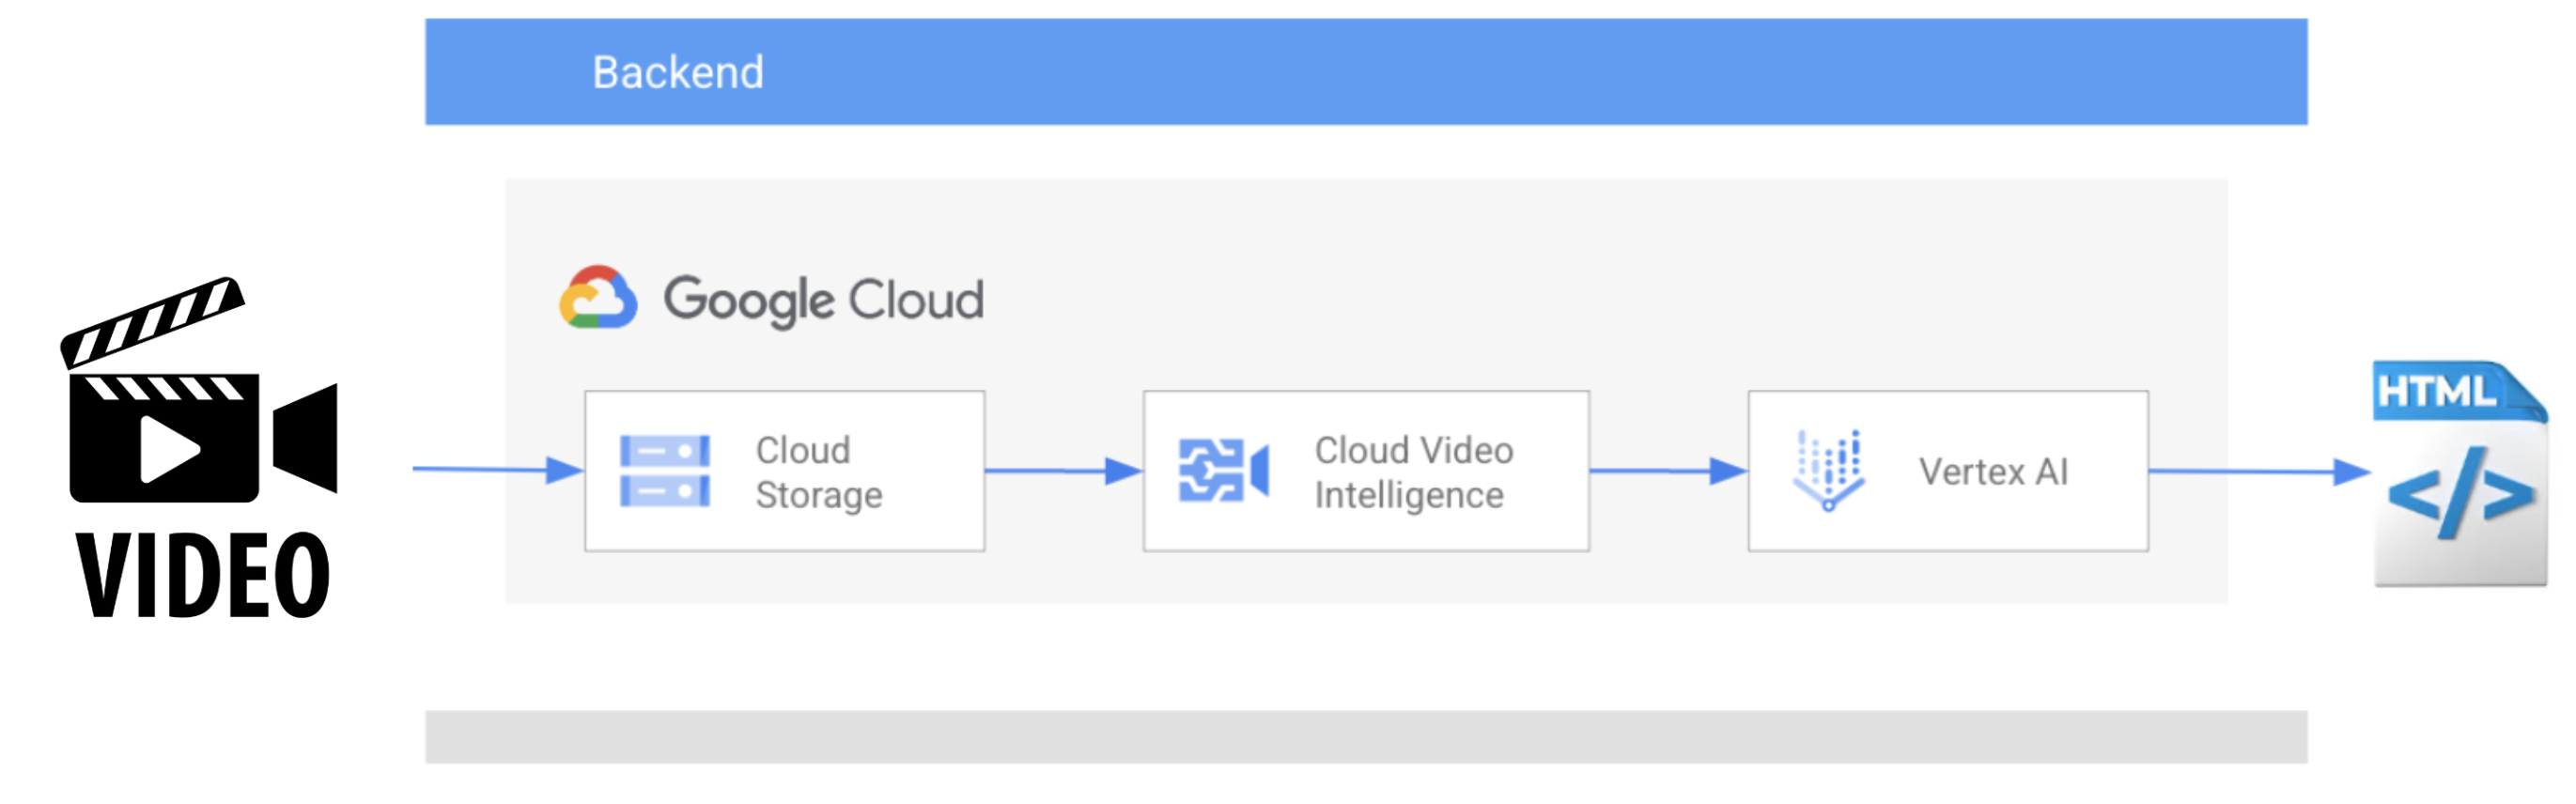

# -2) installations

In [3]:
!pip install pytube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.5 MB/s eta 0:00:00


In [16]:
!pip install google-cloud-videointelligence


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.5/229.5 kB 2.6 MB/s eta 0:00:00a 0:00:01


# -1) import des librairies

In [17]:
"""Transcribe speech from a video stored on GCS."""
from google.cloud import videointelligence
from pytube import YouTube
# Install pytube if not already installed
from pytube import YouTube
from google.cloud import storage
import vertexai
import json


import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display
from sklearn.metrics.pairwise import cosine_similarity
from vertexai.preview.language_models import (ChatModel, InputOutputTextPair,
                                              TextEmbeddingModel,
                                              TextGenerationModel)

# 0) Récupération de la vidéo

# 0.1) upload the file to a bucket

In [ ]:
# Set with your own parameters
bucket_name = "NAME_YOUR_BUCKET"
source_file_path = 'LOCAL_PATH_OF_THE_VIDEO'
destination_blob_name = "UPLOAD_PATH_OF_THE_VIDEO_IN_THE_BUCKET"


In [106]:
def upload_file_to_gcs(bucket_name, source_file_path, destination_blob_name):
    """
    Uploads a file to a Google Cloud Storage bucket.

    Args:
    bucket_name: The name of the bucket to upload to.
    source_file_path: The path to the local file to upload.
    destination_blob_name: The name to give the uploaded blob.

    Returns:
    A blob object representing the uploaded file.
    """

    # Create a client object.
    client = storage.Client()

    # Get the bucket.
    bucket = client.bucket(bucket_name)

    # Create a new blob object.
    blob = bucket.blob(destination_blob_name)

    # Upload the file from the local path.
    blob.upload_from_filename(source_file_path)

    # Return the uploaded blob.
    return blob


uploaded_blob = upload_file_to_gcs(bucket_name, source_file_path, destination_blob_name)

print(f"File {source_file_path} uploaded to {uploaded_blob.name} in bucket {bucket_name}")

File /home/jupyter/generative-ai/language/Conseil municipal du mardi 7 novembre 2023.3gpp uploaded to noumea_conseil_municipal_du_mardi_7_novembre_2023.mp4 in bucket input-video-files-jr


# 2) speech to text

# 2.1) paramètres

In [403]:
input_uri = f"gs://{bucket_name}/{destination_blob_name}"
language_code="fr-FR"

In [51]:
features     = [videointelligence.Feature.SPEECH_TRANSCRIPTION]

config = videointelligence.SpeechTranscriptionConfig(
    language_code=language_code, 
    enable_automatic_punctuation=True,
    enable_speaker_diarization=True,  # Add this line
    diarization_speaker_count=10,
)


# 2.2) instanciation des classes

In [52]:
video_client = videointelligence.VideoIntelligenceServiceClient()
video_context = videointelligence.VideoContext(speech_transcription_config=config)

In [53]:
operation = video_client.annotate_video(
    request={
        "features": features,
        "input_uri": input_uri,
        "video_context": video_context,
    }
)


# 3) Vidéo Transcription (speech to text)

In [ ]:
print("\nProcessing video for speech transcription.")
result = operation.result(timeout=3600)

In [ ]:
annotation_results = result.annotation_results[0]

## 3.1) concatenation des mots, avec timestamp, dans une chaîne contenant tout le transcript

In [377]:
text_transcription = ""
last_timestamp = False
for speech_transcription in annotation_results.speech_transcriptions:
    for alternative in speech_transcription.alternatives:
        for word_info in alternative.words:            
            nb_minutes = str(word_info.start_time.seconds/60)
            timestamp = nb_minutes[:nb_minutes.find(".")+2]
            if timestamp[-2:] in ['.5', '.0'] and timestamp!=last_timestamp:
                text_transcription = text_transcription + f"[timestamp = {float(timestamp)*60} Sec.]" + " " +word_info.word
                last_timestamp = timestamp
            else:
                text_transcription = text_transcription + " " +word_info.word
                
            

In [378]:
transcription_timee2 = text_transcription

# 4) Gen AI 

# 4.0) setting variables

In [408]:
PROJECT_ID = "YOUR_PROJECT_ID"
vertexai.init(project=PROJECT_ID, location="us-central1")

## 4.1) utilisation du modèle choisi

In [122]:
generation_model = TextGenerationModel.from_pretrained("text-bison@002")

 A large language model (LLM) is a type of artificial intelligence (AI) that can understand and generate human language. LLMs are trained on massive datasets of text and code, and they learn to identify patterns and relationships in language. This allows them to generate text that is both coherent and informative.

LLMs are used in a variety of applications, including:

* **Natural language processing (NLP)**: LLMs can be used to perform a variety of NLP tasks, such as machine translation, text summarization, and question answering.
* **Chatbots**: LLMs can be used to create chatbots that can interact


## 4.2)  Prompt engineering

In [386]:
data_json      = []
debut = 0
fin = 0
step = 10000

while fin < len(transcription_timee2): 
    fin += step
    prompt = f"""Voici une transcription d'une vidéo.
    Il y a plusieurs orateurs, et je ne sais pas à quel endroit de la conversation les orateurs changent. 
    Il faut que tu détectes à travers l'analyse du texte, des formules de politesse et des formules de passation de prise de paroles, les parties du texte qui sont énoncées par une personne puis une autre. 
    
    Retourne moi le texte avec un json à chaque fois que l'orateur change. 
    Tu as une limite dans le nombre de caractères que tu peux créer => arrête toi avant d'avoir atteint cette limite, afin d'être sûr de bien terminer le tableau de json !
    Les jsons doivent avoir les champs suivants : 
    - timestamp : le timestamp de début de l'intervention
    - orateur : le nom de l'orateur (si possible) 
    - résumé : un résumé de ce qui est dit
    - lien : un lien html vers https://www.youtube.com/watch?v=MFp4avqwJME qui pointe sur l'heure de début (en utilisant le paramètre &t=) 


    <transcription>
    {transcription_timee2[debut:fin]}
    </transcription>"""
    debut += step
    response = generation_model.predict(prompt=prompt, max_output_tokens=2000)

    string_json    = response.text
    
    last_object_end = max(string_json.rfind("},"), string_json.rfind("}"))

    # Tronquer la chaîne à la fin du dernier objet JSON valide
    json_string_truncated = string_json[:last_object_end + 1]

    # Ajouter la fermeture de tableau si nécessaire
    json_string_truncated += ']'
    
    
    substring_json = json_string_truncated[8:]
    data_json.append( json.loads(substring_json))
    print(".")

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


# 5) output en html

In [391]:
sep = "\n - "
sep1 = "<ul>"
sep2 = "</ul>"
last_debut = data_json[0][0]["timestamp"]
last_orateur = data_json[0][0]["orateur"]
last_résumé = sep1 + "\n<li>"+ data_json[0][0]["résumé"]
last_lien = data_json[0][0]["lien"]
html = ""
for data1 in data_json:
    for data in data1:
        orateur = data["orateur"]


        if orateur != last_orateur:

            
            new_link = f'<a href="#" data-timestamp="{str(last_debut)[:str(last_debut).find(".")]}" onclick="loadVideoAtTimestamp(this)">Load video at {str(last_debut)[:str(last_debut).find(".")]}s</a>'
            
            html += f"<h2>{last_debut} : {last_orateur} {new_link}</h2>\n"
            html += f"{last_résumé}</ul>\n"

            last_debut = data["timestamp"]
            last_orateur = data["orateur"]
            last_résumé = "<ul> <li>" + data["résumé"]  + "</li>"
            last_lien = sep + data["lien"]
        else:
            last_résumé  = last_résumé + "\n<li>" + data["résumé"]  + "</li>"


## 5.1) HTML

In [409]:
youtube_include = """
<!DOCTYPE html>
<html>
<head>
    <title>Your Page Title</title>
    <!-- Your CSS and other head content here -->
</head>

<head>
    <title>Your Page Title</title>
    <!-- Your CSS and other head content here -->

     <style type="text/css">
        body {
    font-family: 'Arial', sans-serif;
    background-color: #f4f4f4;
    color: #333;
    line-height: 1.6;
    padding: 20px;
}
.fixed-height-text {
    height: 400px; /* Set your desired height */
    overflow: auto; /* Enables scrolling if content exceeds the height */
    /* Add any additional styling like padding, border, etc. */
}
iframe {
    width: 100%;
    max-width: 800px; /* Adjust based on your preference */
    margin-bottom: 20px;
    
}

h2 {
    background-color: #007bff;
    color: white;
    padding: 10px;
    border-radius: 5px;
}

ul {
    list-style: inside square;
    padding-left: 20px;
}

li {
    margin-bottom: 10px;
}

a {
    color: #ff4500; /* Adjust the color to make it more visible */
    text-decoration: none;
}

a:hover {
    color: #ff6347; /* A slightly different color for hover effect */
    text-decoration: underline;
}

/* Responsive design for smaller screens */
@media screen and (max-width: 600px) {
    body {
        padding: 10px;
    }

    h2 {
        font-size: 1em;
    }
}

    </style>
</head>
<body>
    <iframe id="videoPlayer" width="560" height="315" src="https://www.youtube.com/embed/MFp4avqwJME?si=xbl7f5hOhI6PJBg5" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

"""

In [410]:
html_footer = """
<script>
    var loadCounter = 0;

    function loadVideoAtTimestamp(element) {
        var timestamp = element.getAttribute('data-timestamp');
        var iframe = document.getElementById('videoPlayer');
        iframe.src = 'https://www.youtube.com/embed/MFp4avqwJME?start=' + timestamp + '&loadCounter=' + loadCounter;
        loadCounter++; // Increment the counter to ensure a unique URL each time
        return false; // Prevent default action of the link
    }
</script>

</body>
</html>

"""

## 5.2) save to a file

In [411]:
with open("noumea.html", "w") as f:
    f.write(youtube_include + html + html_footer)

# End